# Visualize & Analyze Word2Vec Model

https://github.com/lknelson/measuring_intersectionality/blob/main/scripts/01_measuringintersectionality_reproduceanalysis.ipynb

In [90]:
import sys, os, random, warnings, gensim
import pandas as pd
import numpy as np

# Primary visualizations
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

# PCA visualization
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise
from sklearn.manifold import MDS, TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Ignore warnings.
warnings.filterwarnings("ignore")

# Declare absolute path.
abs_dir = "/Users/quinn.wi/Documents/"

In [52]:
%%time

def tuple_to_dict(mytuple):
    """
    Input a tuple, output a dictionary
    """
    
    mydict = {}
    for key, value in mytuple:
        if key not in mydict:
            mydict[key] = value
    return mydict

# Load model.
model = gensim.models.KeyedVectors.load_word2vec_format(abs_dir + '/Data/Output/WordVectors/jqa_w2v.txt')

CPU times: user 416 ms, sys: 5.89 ms, total: 422 ms
Wall time: 429 ms


## Data Check

In [95]:
print(model.similarity('boston', 'federalist'))
print(model.similarity('british', 'federalist'))

print ('\nWords most similar to "home":\n', [word for word, score in model.most_similar(['home'])], '\n')

print ('Words most similar to "work":\n', [word for word, score in model.most_similar(['work'])], '\n')

print ('Word most similar to "freedom + congress - britain":\n', 
       model.most_similar(positive = ['freedom', 'congress'], negative = ['britain'], topn = 4))

0.5863241
0.31527692

Words most similar to "home":
 ['lodgings', 'midnight', 'walking', 'drawingroom', 'dark', 'dining', 'tavern', 'hills', 'stopped', 'wasted'] 

Words most similar to "work":
 ['convenient', 'deficiency', 'neglected', 'labour', 'deliberate', 'study', 'continuing', 'regular', 'occupation', 'neglect'] 

Word most similar to "freedom + congress - britain":
 [('ensuing', 0.6747051477432251), ('commencement', 0.660179078578949), ('houses', 0.6533211469650269), ('committees', 0.6435043811798096)]


## t-SNE Visualization

<Figure size 1800x1080 with 0 Axes>

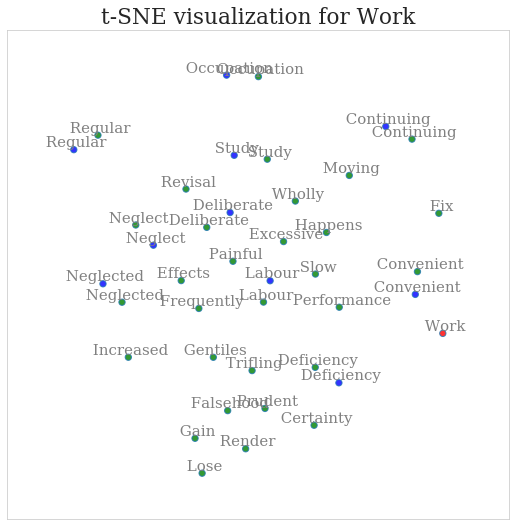

In [145]:
# sns.set_style('darkgrid')
sns.set_style("whitegrid", {'axes.grid' : False})

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

palette = sns.color_palette("Set1", 4)

plt.figure(figsize=(25,15))



# https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial
def tsnescatterplot(model, word, list_names):
    """
    Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    
    arrays = np.empty((0, 100), dtype='f') # 100 == vector size when model was created.
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:        
        wrd_vector = model.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.__getitem__([wrd[0]])
        word_labels.append(wrd[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to x dimensions with PCA; error will arise if x is too large.
    reduc = PCA(n_components=41).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
#     # Adds annotations one by one with a loop
#     for line in range(0, df.shape[0]):
#          p1.text(df["x"][line],
#                  df['y'][line],
#                  '  ' + df["words"][line].title(),
#                  horizontalalignment='left',
#                  verticalalignment='bottom', size='medium',
#                  color=df['color'][line],
#                  weight='normal'
#                 ).set_size(15)
            
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("")
    plt.ylabel("")


    # add annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df['x'][line], 
                  df['y'][line], 
                  ' ' + df['words'][line].title(),
                  horizontalalignment = 'center', 
                 verticalalignment = 'bottom',
                  size = 'small', 
                  color = 'gray', 
                  weight = 'normal')

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

tsnescatterplot(model, 
                'work', 
                model.most_similar(['work'], topn = 30))

## PCA Visualization

In [91]:
%%time

count = len(model)
n = 50

#50 words with highest cosine similarity to the five social institutions

polity = model.most_similar(['nation', 'state'], topn=count)
polity_dict = tuple_to_dict(polity)
polity_words = [word for word, score in polity][:n]

authority = model.most_similar(['authority'], topn=count)
authority_dict = tuple_to_dict(authority)
authority_words = [word for word, score in authority][:n]

# domestic = model.most_similar(['home', 'children'], topn=count)
# domestic_dict = tuple_to_dict(domestic)
# domestic_words = [word for word, score in domestic][:n]

# Create dataframe of main model data for easier visualization
rows = polity_words + authority_words

keyword_dict = {}
keyword_dict['polity'] = polity_dict
keyword_dict['authority'] = authority_dict
# keyword_dict['domestic'] = domestic_dict

df = pd.DataFrame(keyword_dict)
df = df.loc[rows]
df[''] = ''

# Domains
for word in polity_words:
    df.loc[word, ''] = 'Polity Words'

for word in authority_words:
    df.loc[word, ''] = 'Authority Words'

# for word in domestic_words:
#     df.loc[word, ''] = 'Domestic Words'


    
df_mds = df[['polity', 'authority']]
df_mds['polity'] = 1 - df_mds['polity']
df_mds['authority'] = 1 - df_mds['authority']
# df_mds['domestic'] = 1 - df_mds['domestic']

feat_cols = ['polity', 'authority'] #, 'domestic']

np.random.seed(42)
rndperm = np.random.permutation(df_mds.shape[0])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_mds[feat_cols].values)

df_mds['pcaone'] = pca_result[:,0]
df_mds['pcatwo'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

df_mds

Explained variation per principal component: [0.80994685 0.19005315]
CPU times: user 368 ms, sys: 8.47 ms, total: 377 ms
Wall time: 64.4 ms


,polity,authority,pcaone,pcatwo
retrenchment,0.185596,0.351275,0.090534,-0.045053
interior,0.196236,0.406642,0.128694,-0.003549
preference,0.199595,0.300076,0.041060,-0.064278
critical,0.202565,0.422405,0.137594,0.010919
patronage,0.206085,0.363925,0.088505,-0.021059
...,...,...,...,...
modification,0.381678,0.265004,-0.095498,0.061167
avail,0.266207,0.266724,-0.025389,-0.030600
emperors,0.357939,0.267260,-0.079555,0.043433
purposely,0.319832,0.268235,-0.056091,0.013391


No handles with labels found to put in legend.


CPU times: user 63.5 ms, sys: 2.14 ms, total: 65.6 ms
Wall time: 65.3 ms


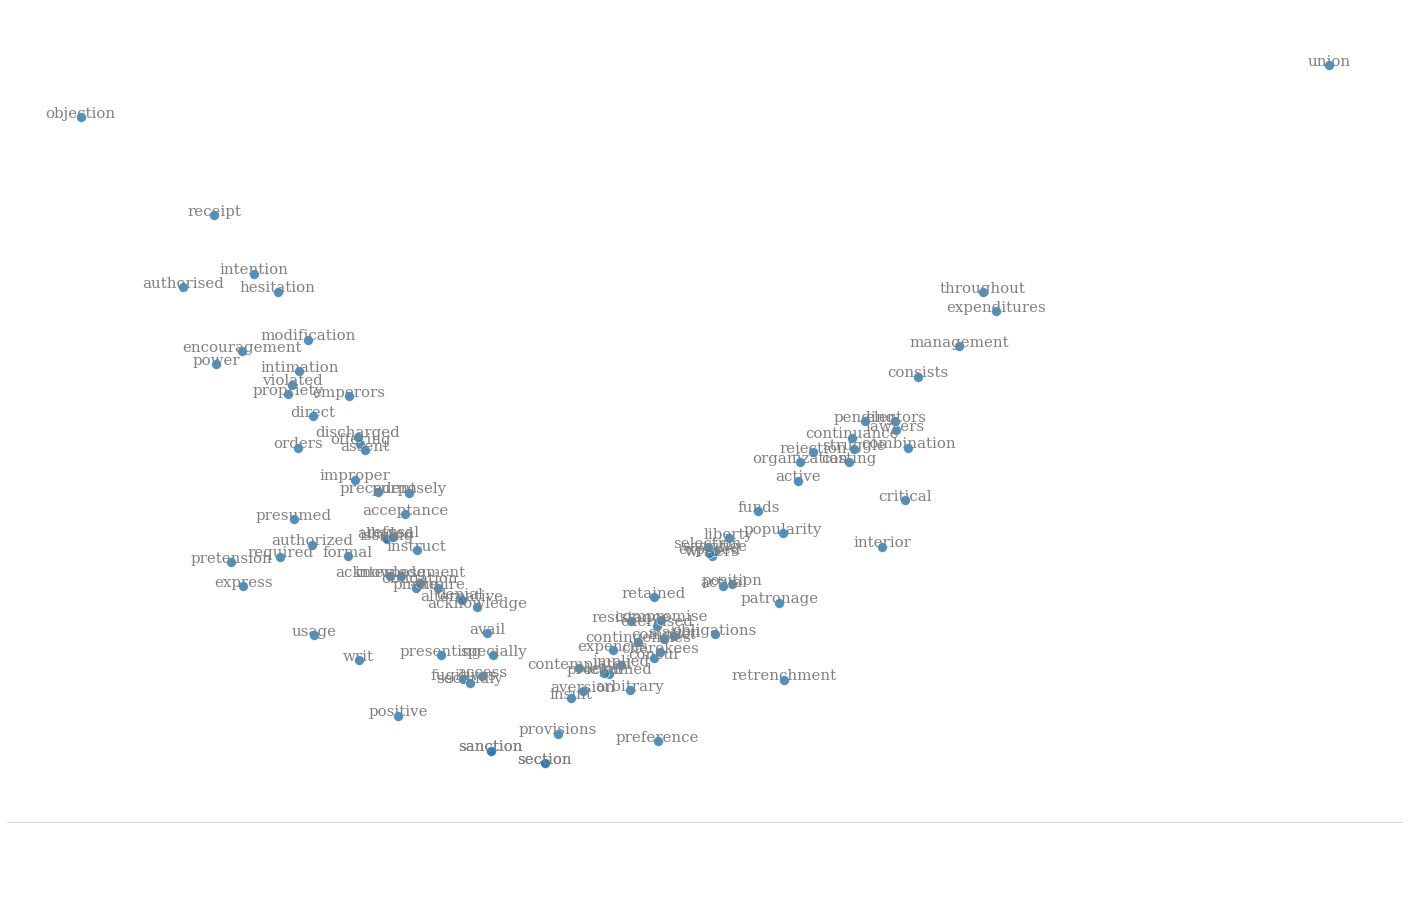

In [85]:
%%time

sns.set_style("whitegrid", {'axes.grid' : False})

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

palette = sns.color_palette("Set1", 4)

plt.figure(figsize=(25,15))

fig = sns.scatterplot(
    x = "pcaone",
    y = "pcatwo",
#     hue = "",
    palette = palette,
    data = df_mds,
    hue_order = ['polity', 'authority'],
    legend = "full",
    alpha = 0.8,
    s = 100
)

plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")

fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
fig.spines['left'].set_visible(False)

# add annotations one by one with a loop
for line in range(0, df_mds.shape[0]):
     fig.text(df_mds.pcaone[line], 
             df_mds.pcatwo[line], 
             df_mds.index[line], 
             horizontalalignment = 'center', 
             size = 'small', 
             color = 'gray', 
             weight = 'normal')
        
fig.legend(loc = 'upper center', 
            bbox_to_anchor = (0.5, -0.05), 
            ncol = 5,
            fontsize = 'large',
            markerscale = 4,
            frameon = False,
            )